In [1]:
!pip install boto3

In [5]:
from __future__ import print_function
import requests
import sys
import io
import json
import shutil
import sys
import datetime
import subprocess
import sys
import os
import math
import base64
from time import gmtime, strftime
import random, string
import time
import psutil
import base64
import uuid
import socket
import os
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import torch
from torchvision import transforms
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from pymilvus import MilvusClient
import os
from IPython.display import display

In [6]:
from __future__ import print_function
import requests
import sys
import io
import json
import shutil
import sys
import datetime
import subprocess
import sys
import os
import math
import base64
from time import gmtime, strftime
import random, string
import time
import psutil
import base64
import uuid
import socket
import os
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import torch
from torchvision import transforms
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from pymilvus import MilvusClient
import os
from IPython.display import display

In [8]:
# -----------------------------------------------------------------------------

class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

In [9]:
extractor = FeatureExtractor("resnet34")

# -----------------------------------------------------------------------------
# Constants - should be environment variables
# -----------------------------------------------------------------------------
DIMENSION = 512 
MILVUS_URL = "http://192.168.1.163:19530" 
COLLECTION_NAME = "pidetections"
BUCKET_NAME = "images"
DOWNLOAD_DIR = "/Users/timothyspann/Downloads/code/images/"
AWS_RESOURCE = "s3"
S3_ENDPOINT_URL = "http://192.168.1.163:9000"
AWS_ACCESS_KEY = "minioadmin" 
AWS_SECRET_ACCESS_KEY = "minioadmin"
S3_SIGNATURE_VERSION = "s3v4"
AWS_REGION_NAME = "us-east-1"
S3_ERROR_MESSAGE = "Download failed"
# -----------------------------------------------------------------------------

In [10]:
# -----------------------------------------------------------------------------
# Connect to Milvus

# Local Docker Server
milvus_client = MilvusClient( uri=MILVUS_URL)
# -----------------------------------------------------------------------------

Detection: keyboard 0.72 for keyboardb2d1c501-9aae-4bb1-8f93-48942283133d.jpg from images/keyboardb2d1c501-9aae-4bb1-8f93-48942283133d.jpg


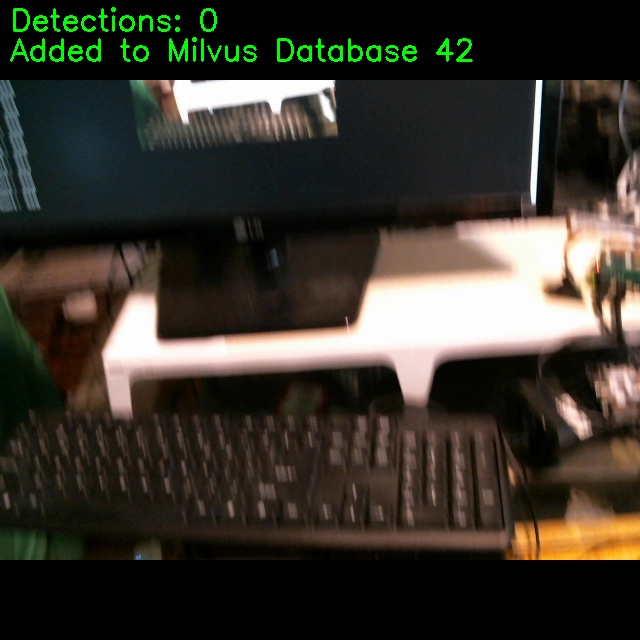

Detection: keyboard 0.64 for keyboardde59944e-2a61-4ae8-8e0a-fbe8ebdf2db7.jpg from images/keyboardde59944e-2a61-4ae8-8e0a-fbe8ebdf2db7.jpg


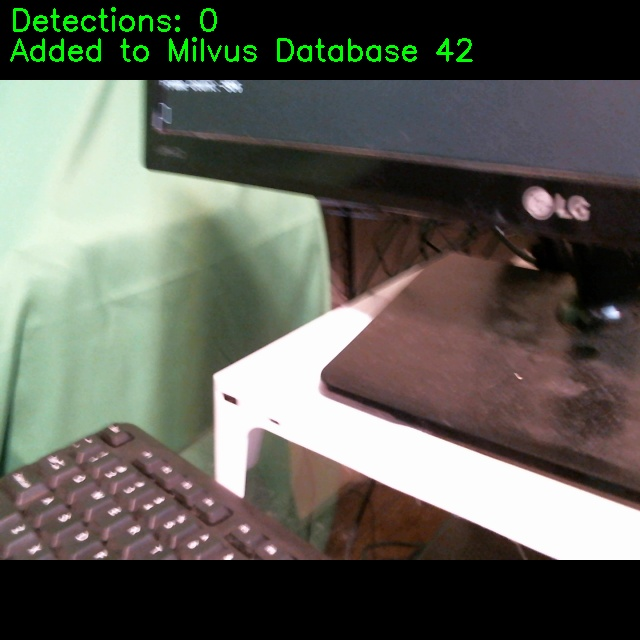

Detection: keyboard 0.84 for keyboard68d267a1-f2b7-40b4-b398-7552a6bbd2e7.jpg from images/keyboard68d267a1-f2b7-40b4-b398-7552a6bbd2e7.jpg


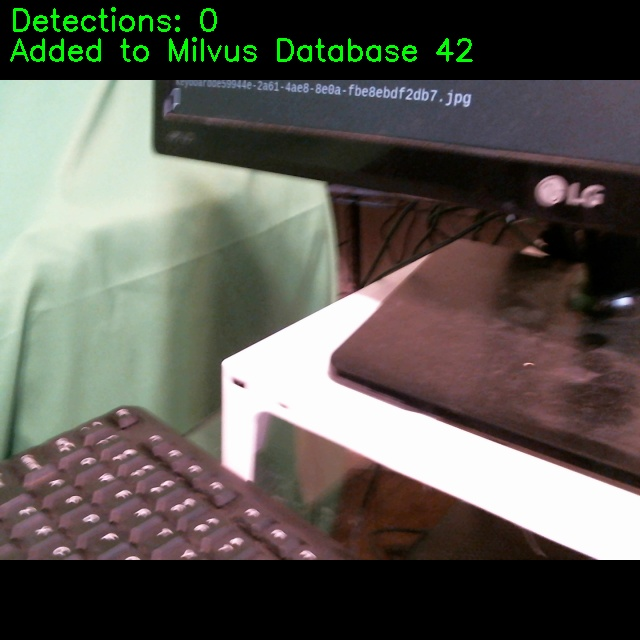

Detection: keyboard 0.82 for keyboard6cf98aa6-4fcb-4eb9-b507-e1f503743bc1.jpg from images/keyboard6cf98aa6-4fcb-4eb9-b507-e1f503743bc1.jpg


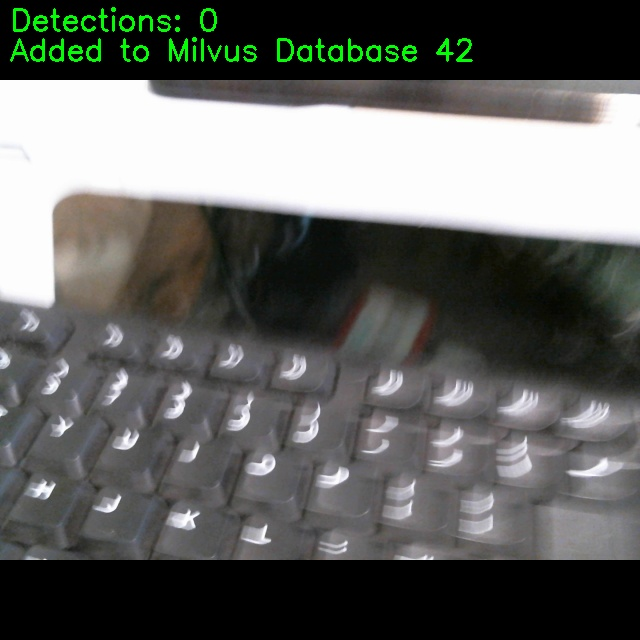

In [11]:
import os
import boto3
from botocore.client import Config

# -----------------------------------------------------------------------------
# Access Images on S3 Compatible Store - AWS S3 or Minio or ...
# -----------------------------------------------------------------------------
s3 = boto3.resource(AWS_RESOURCE,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        config=Config(signature_version=S3_SIGNATURE_VERSION),
        region_name=AWS_REGION_NAME)

bucket = s3.Bucket(BUCKET_NAME)

# -----------------------------------------------------------------------------
# Get last modified image
# -----------------------------------------------------------------------------
files = bucket.objects.filter()
files = [obj.key for obj in sorted(files, key=lambda x: x.last_modified, 
    reverse=True)]

for imagename in files:
    query_image = imagename
    break

search_image_name = DOWNLOAD_DIR + query_image

try:
    s3.Bucket(BUCKET_NAME).download_file(query_image, search_image_name)
except botocore.exceptions.ClientError as e:
    print(S3_ERROR_MESSAGE)

# -----------------------------------------------------------------------------
# Search Milvus for that vector and filter by a label
# -----------------------------------------------------------------------------
results = milvus_client.search(
    COLLECTION_NAME,
    data=[extractor(search_image_name)],
    filter='label in ["keyboard"]',
    output_fields=["label", "confidence", "id", "s3path", "filename"],
    search_params={"metric_type": "COSINE"},
    limit=5
)

# -----------------------------------------------------------------------------
# Iterate through last five results and display metadata and image
# -----------------------------------------------------------------------------
for result in results:
    for hit in result[:5]:
        label = hit["entity"]["label"]
        confidence = hit["entity"]["confidence"]
        filename = hit["entity"]["filename"]
        s3path = hit["entity"]["s3path"]
        try:
            s3.Bucket(BUCKET_NAME).download_file(filename, DOWNLOAD_DIR + filename)
        except botocore.exceptions.ClientError as e:
            print(S3_ERROR_MESSAGE)
        print(f"Detection: {label} {confidence:.2f} for {filename} from {s3path}" )
        img = Image.open(DOWNLOAD_DIR + filename)
        display(img)   
        
# Enhancement:  we could also post this to slack or discord